In [2]:
import os
import sys
import itertools

import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.signal as sig
import scipy.io as spio


import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import networkx as nx
import community
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

sys.path.append("../../../code/ndsvae/")
import ndsvae as ndsv

sys.path.append("../")
import util
import plotutils as pu

%matplotlib inline

In [12]:
configs = ["ns_1_mreg_3_msub_2_nf_32", "ns_2_mreg_3_msub_2_nf_32",
           "ns_3_mreg_3_msub_2_nf_32", "ns_4_mreg_3_msub_2_nf_32", "ns_5_mreg_3_msub_2_nf_32"]

conn = "linw"
preproc = "dicer"
modelname = "AB"

nconf = len(configs)

In [13]:
ds = ndsv.Dataset.from_file(f"../run/hcp/hcp_{conn}_{preproc}/dataset.npz")
runs = [util.select_run(f"hcp_{conn}_{preproc}", modelname, config, [0,1], "hcp") for config in configs]
direcs = [f"../run/hcp/hcp_{conn}_{preproc}/model{modelname}/{config}/run{run:02d}" 
         for config, run in zip(configs, runs)]
paramss = [ndsv.Params.from_file(os.path.join(direc, "parameters.npz")) for direc in direcs]

In [14]:
nsub, nreg, _, nt = ds.y.shape
subjects = np.r_[:nsub]
regions = np.r_[:nreg]

## Calculate KL

In [22]:
def calc_kl_timeseries(x, nsamples=10):
    nsub, nreg, ns, nt, _ = x.shape
        
    kl = np.full((nsub, nreg, ns, nt-1), np.nan)

    for (isub, ireg) in itertools.product(range(nsub), range(nreg)):
        xr = x[isub,ireg,:,1:,:]  # Note: we are removing the initial conditions
        ntm = nt - 1
        
        x1mu, x1std  = xr[:,:,0], xr[:,:,1]        
        xsamples = np.random.normal(x1mu[:,:,None], x1std[:,:,None], size=(ns, ntm, nsamples))        
        x2mu  = np.mean(np.reshape(xsamples, (ns, ntm*nsamples)), axis=1)
        x2std = np.std(np.reshape(xsamples, (ns, ntm*nsamples)), axis=1)

        for i in range(ns):
            kl[isub,ireg,i,:] = (np.log(x2std[i]/x1std[i]) 
                                 + (x1std[i]**2 + (x1mu[i] - x2mu[i])**2)/(2*x2std[i]**2) - 0.5)
    return np.mean(kl, axis=(0,1,3))

In [53]:
np.random.seed(42)
calc_kl_timeseries(paramss[3].x)

kls = [calc_kl_timeseries(params.x) for params in paramss]
order = [np.argsort(-kl) for kl in kls]
sorted_kls = [kl[o] for kl, o in zip(kls, order)]

In [54]:
print("      ns=1      ns=2      ns=3      ns=4      ns=5")
print("--------------------------------------------------")

maxns = len(sorted_kls[-1])

for j in range(maxns):
    for i in range(nconf): 
        # klconf = -np.sort([np.mean(-kl[i,:,:,j,1:]) for j in range(ns)])
        
        if j < len(sorted_kls[i]):
            print(f"  & {sorted_kls[i][j]:6.3f}", end='')
        else:
            print("  &    -  ", end='')
    print("  \\\\")

      ns=1      ns=2      ns=3      ns=4      ns=5
--------------------------------------------------
  &  2.539  &  3.252  &  3.178  &  3.195  &  3.244  \\
  &    -    &  0.383  &  0.369  &  0.378  &  0.377  \\
  &    -    &    -    &  0.000  &  0.000  &  0.001  \\
  &    -    &    -    &    -    &  0.000  &  0.000  \\
  &    -    &    -    &    -    &    -    &  0.000  \\


In [18]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Arial"

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [56]:
x.shape

(1, 1200, 2)

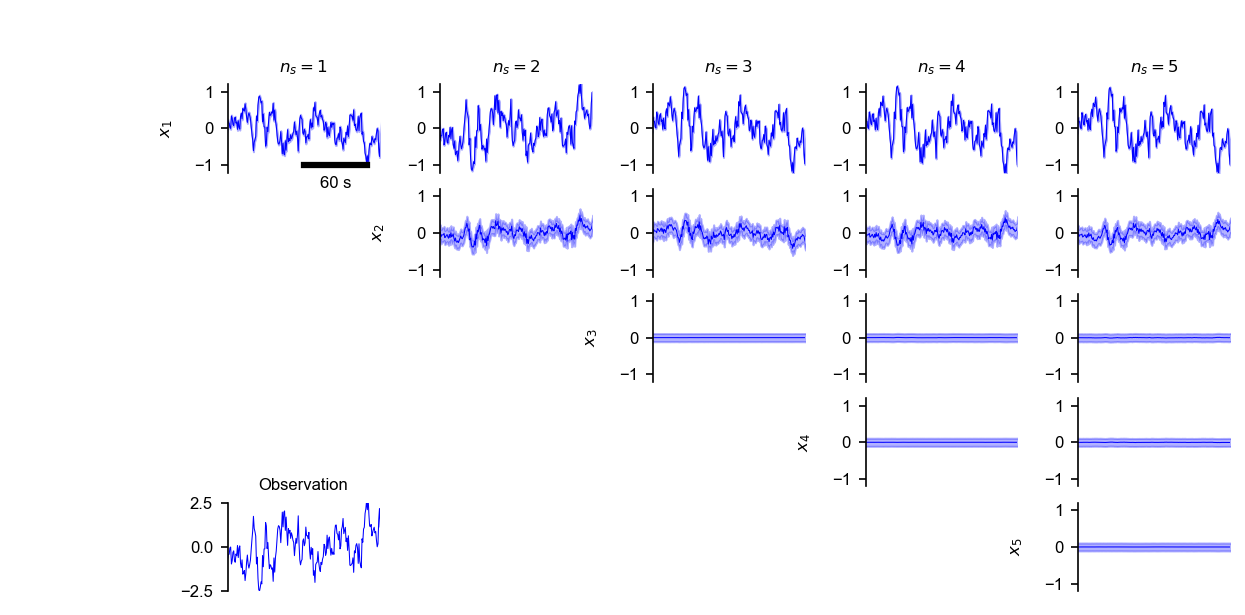

In [57]:
isub = 5
ireg = 40

maxns = 5

fig = plt.figure(figsize=(7.5,4), dpi=150)

gs = GridSpec(maxns+1, maxns+1, width_ratios=[1,1,1,1,1,1], height_ratios=[0.6,1,1,1,1,1],
              hspace=0.2, wspace=0.4, left=-0.1, right=0.98, bottom=0.04, top=1.0)


# Data
ax = plt.subplot(gs[5,1])
plt.plot(ds.y[isub,ireg,0,:], color='b', lw=0.5)
plt.xlim(300, 500)
plt.ylim(-2.5,2.5)
plt.title("Observation")
plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)


# Labels
for i in range(maxns):
    plt.subplot(gs[1+i,i])
    plt.text(1, 0.5, f"$x_{i+1}$", ha='center', va='center', rotation='vertical', fontsize=8)
    plt.axis('off')
    
 
for iconf in range(nconf):
    params = paramss[iconf]
    x = params.x[isub,ireg,:,:,:]
    ns = x.shape[0]

    plt.subplot(gs[0,iconf+1])
    plt.text(0.5, 0., f"$n_s = {ns}$", ha='center', va='center', fontsize=8)
    plt.axis('off')
    
    for i in range(iconf+1):
        ax = plt.subplot(gs[i+1,iconf+1])

        if i >= ns: continue        
        ind = order[iconf][i]
        
        plt.plot(x[ind,:,0], color='b', lw=0.5)
        plt.fill_between(np.r_[:nt], x[ind,:,0]-x[ind,:,1], x[ind,:,0]+x[ind,:,1], color='b', alpha=0.3)

        plt.xlim(300, 500)
        plt.ylim(-1.2,1.2)
        
        plt.xticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        
        # Scale
        if iconf == 0 and i == 0:
            dt = ds.t[1] - ds.t[0]
            n60 = 60./dt
            
            plt.plot([400, 400+n60], [-1,-1], lw=3, color='k')
            plt.text(400+n60/2, -1.3, "60 s", ha='center', va='top', fontsize=8)

        
        
plt.savefig("./img/Fig_StateSpace.pdf")